In [250]:
#Import all necessary modules
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import scipy.stats as sc
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
import category_encoders as ce
from sklearn.metrics import plot_roc_curve
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy import stats

In [251]:
#Read in both the files
df_user_eng = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Machine Learning Case Studies/relax_challenge/takehome_user_engagement.csv')
df_users = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Machine Learning Case Studies/relax_challenge/takehome_users.csv',engine='python')

In [252]:
df_user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [253]:
df_user_eng.shape

(207917, 3)

In [254]:
#Convert to a date time object
df_user_eng['time_stamp'] = pd.to_datetime(df_user_eng['time_stamp'])

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

In [255]:
#Group by user id and resample by week aggregating as a sum
df_user_grouped = df_user_eng.set_index('time_stamp').groupby('user_id').resample('W').sum()

In [256]:
df_user_grouped.head()

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0

In [257]:
#Create a boolean based on the sum for visited being 1 if it's >=3 and 0 otherwise
df_user_ind = df_user_grouped.reset_index(level='time_stamp').drop(['user_id','time_stamp'],axis=1).reset_index()
df_user_ind['adopt_bool'] = 0
df_user_ind.loc[df_user_ind['visited']>=3,'adopt_bool']=1
df_user_ind.head()

,user_id,visited,adopt_bool
0,1,1,0
1,2,1,0
2,2,0,0
3,2,1,0
4,2,0,0


In [258]:
#Again group by users to create a unique list of users and whether they are adopted users or not
df_user_eng_list = df_user_ind.groupby('user_id').sum().reset_index()
df_user_eng_list['adopted_user'] = 0
df_user_eng_list.loc[df_user_eng_list['adopt_bool']!=0,'adopted_user'] = 1
user_eng_list = df_user_eng_list[['user_id','adopted_user']]

In [259]:
#Create a list of all users not in the engagement dataframe and assign them as non-adopted users
non_eng_list = pd.DataFrame(list(set(df_users['object_id'])-set(user_eng_list['user_id']))).rename(columns={0:'user_id'})
non_eng_list['adopted_user'] = 0
all_users = pd.concat([user_eng_list,non_eng_list])
#Dictionary of all users and their adopted user status
user_dict = dict(zip(all_users['user_id'],all_users['adopted_user']))

In [260]:
#Create an adopted user target variable for the users dataframe
df_users_ad = df_users.copy()
df_users_ad['adopted_user'] = df_users_ad['object_id'].map(user_dict)

In [261]:
df_users_ad['adopted_user'].value_counts(normalize=True)

0    0.879583
1    0.120417
Name: adopted_user, dtype: float64

As seen above, the data is imbalanced in favor of non-adopted users

In [262]:
df_users_ad.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [263]:
#Convert creation time and last session creation times to a date time object
df_users_ad['last_session_creation_time'] = pd.to_datetime(df_users_ad['last_session_creation_time'],unit='s')
df_users_ad['creation_time'] = pd.to_datetime(df_users_ad['creation_time'])

In [264]:
df_users_ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)


In [265]:
#Create date time features for creation_time and last_session_creation_time
def time_features(df,variable):
    df[variable+'_Year'] = df[variable].dt.year
    df[variable+'_Month_No'] = df[variable].dt.month
    df[variable+'_Day_of_Week'] = df[variable].dt.dayofweek
    df[variable+'_Hour'] = df[variable].dt.hour
    df[variable+'_Day'] = df[variable].dt.day_name()
    df[variable+'_Month'] = df[variable].dt.month_name()
    df[variable+'_Y/M'] = (df[variable].dt.to_period('M')).dt.strftime('(%Y, %m)')
    return df

Extracting time features for creation time and last session creation time to analyze effects of month, day, hour on the count of adopted users

In [266]:
#Extract time features
df_users_ad = time_features(df_users_ad,'creation_time')
df_users_ad = time_features(df_users_ad,'last_session_creation_time')

In [267]:
df_users_ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   object_id                               12000 non-null  int64         
 1   creation_time                           12000 non-null  datetime64[ns]
 2   name                                    12000 non-null  object        
 3   email                                   12000 non-null  object        
 4   creation_source                         12000 non-null  object        
 5   last_session_creation_time              8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list                12000 non-null  int64         
 7   enabled_for_marketing_drip              12000 non-null  int64         
 8   org_id                                  12000 non-null  int64         
 9   invited_by_user_id                      6417 non-n

Missing data columns such as invited by user id can be dropped. Regarding last session creation time, the missing rows could be imputed by an average date as long as it is the same or later than creation time.
Alternatively, the missing rows also could be dropped directly.

In [268]:
df_users_ad.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,creation_time_Day,creation_time_Month,creation_time_Y/M,last_session_creation_time_Year,last_session_creation_time_Month_No,last_session_creation_time_Day_of_Week,last_session_creation_time_Hour,last_session_creation_time_Day,last_session_creation_time_Month,last_session_creation_time_Y/M
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,Tuesday,April,"(2014, 04)",2014.0,4.0,1.0,3.0,Tuesday,April,"(2014, 04)"
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,Friday,November,"(2013, 11)",2014.0,3.0,0.0,3.0,Monday,March,"(2014, 03)"
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,...,Tuesday,March,"(2013, 03)",2013.0,3.0,1.0,23.0,Tuesday,March,"(2013, 03)"
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,...,Tuesday,May,"(2013, 05)",2013.0,5.0,2.0,8.0,Wednesday,May,"(2013, 05)"
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,...,Thursday,January,"(2013, 01)",2013.0,1.0,1.0,10.0,Tuesday,January,"(2013, 01)"


Check the amount of adopted users grouped for month, day and hour

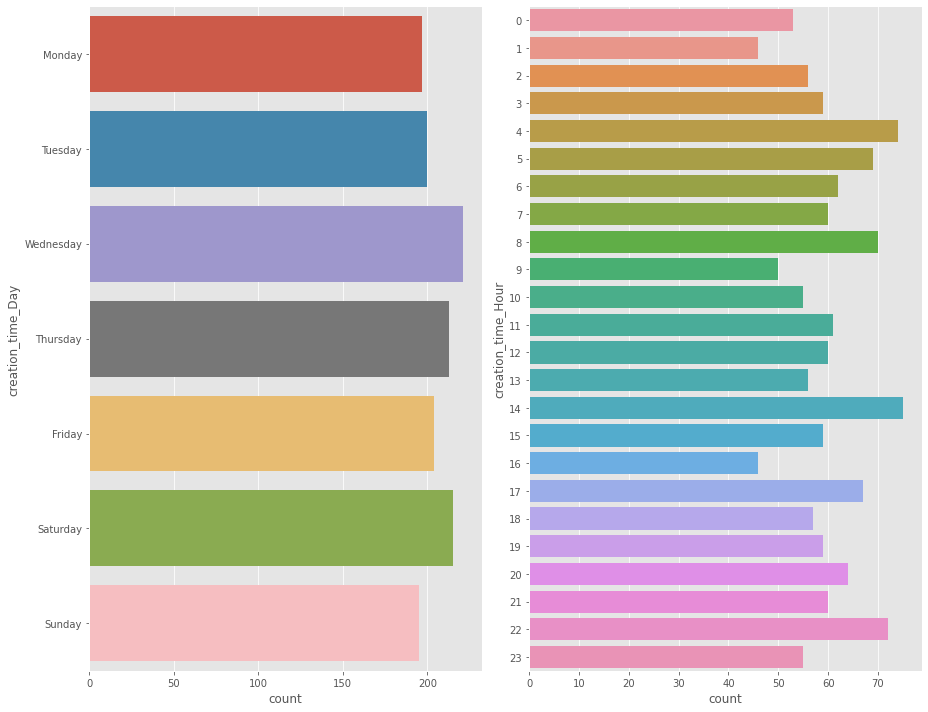

In [269]:
f,ax = plt.subplots(1,2,figsize=(13,10))
day = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(y='creation_time_Day',order=day,data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[0])
sns.countplot(y='creation_time_Hour',data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[1])
plt.tight_layout()

Not a lot of variation by day and hour based on creation time.

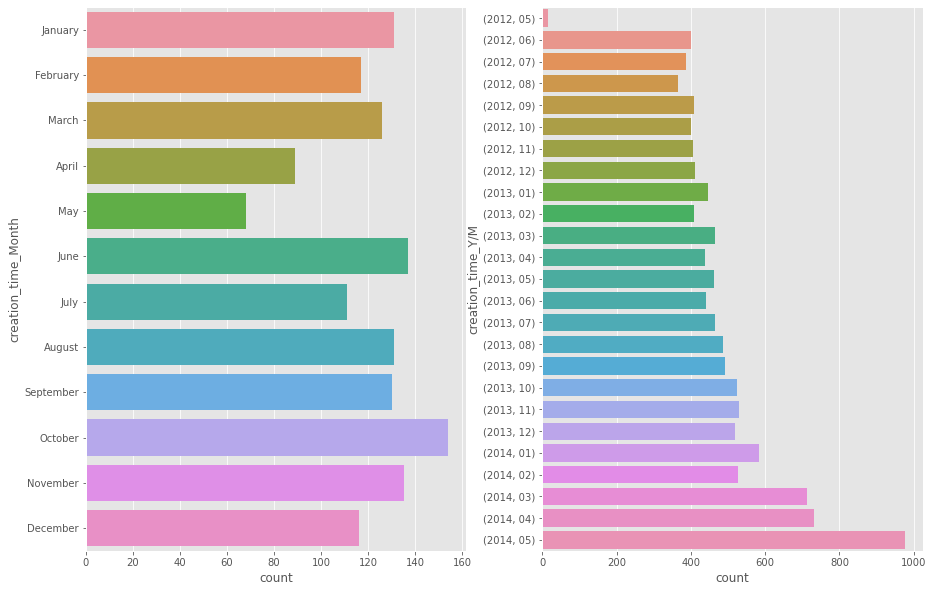

<Figure size 720x360 with 0 Axes>

In [270]:
f,ax = plt.subplots(1,2,figsize=(15,10))
plt.figure(figsize=[10,5])
mth = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.countplot(y='creation_time_Month',order=mth,data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[0])
data_cr = df_users_ad.set_index('creation_time_Y/M').sort_index()
sns.countplot(y=data_cr.index,data=data_cr[data_cr['adopted_user']==1],ax=ax[1])
plt.tight_layout()

Some variation seen for creation time month and adopted users. As seen, the count of users went up consistently in 2014.

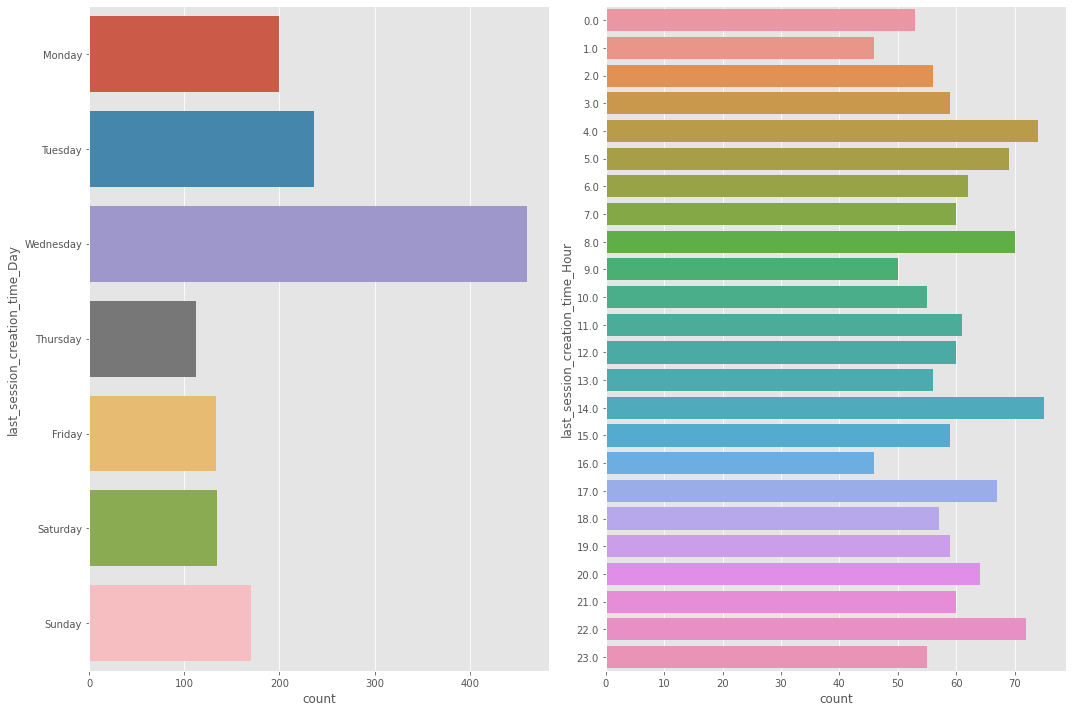

In [271]:
f,ax = plt.subplots(1,2,figsize=(15,10))
day = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(y='last_session_creation_time_Day',order=day,data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[0])
sns.countplot(y='last_session_creation_time_Hour',data=df_users_ad[df_users_ad['adopted_user']==1])
plt.tight_layout()

Last session creation days shows a large spike of adopted users during Wednesday

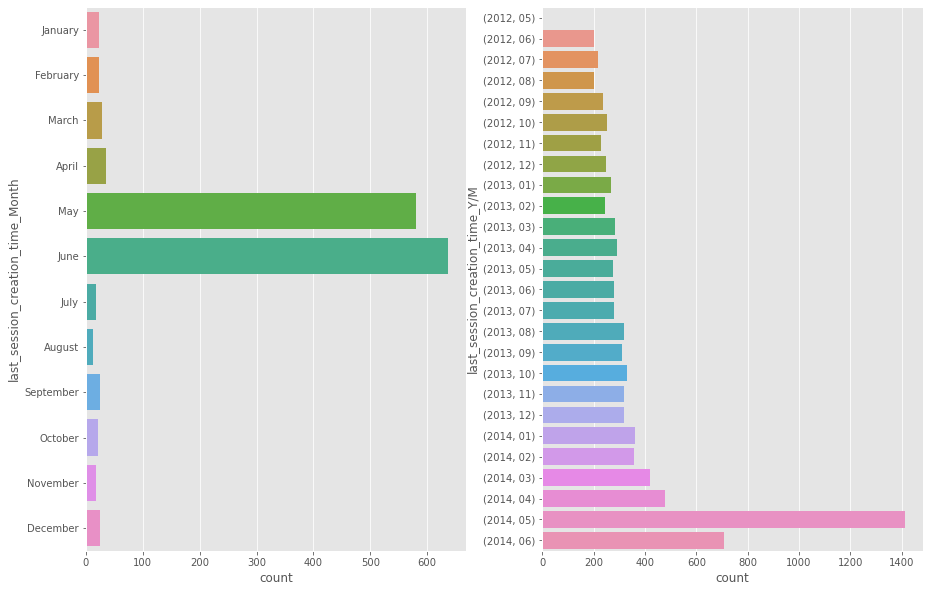

<Figure size 720x360 with 0 Axes>

In [31]:
f,ax = plt.subplots(1,2,figsize=(15,10))
mth = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.figure(figsize=[10,5])
sns.countplot(y='last_session_creation_time_Month',order=mth,data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[0])
data_ls_cr = df_users_ad.set_index('last_session_creation_time_Y/M').sort_index()
sns.countplot(y=data_ls_cr.index,data=data_ls_cr[data_ls_cr['adopted_user']==1],ax=ax[1])
plt.tight_layout()

May and June in 2014 had a significant spike of adopted users. This shows in the overall montly values for adopted users. Creation time also had more adopted users during April and May in 2014 than other months.
Both creation time and last session time could have good predictive power

In [272]:
df_users_ad['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

<AxesSubplot:xlabel='count', ylabel='creation_source'>

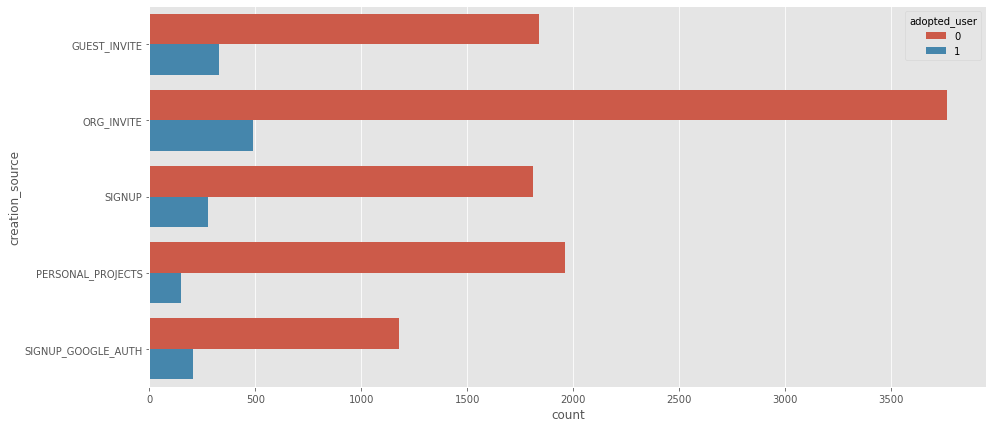

In [273]:
plt.figure(figsize=[15,7])
sns.countplot(y='creation_source',hue='adopted_user',data=df_users_ad)

<AxesSubplot:xlabel='count', ylabel='creation_source'>

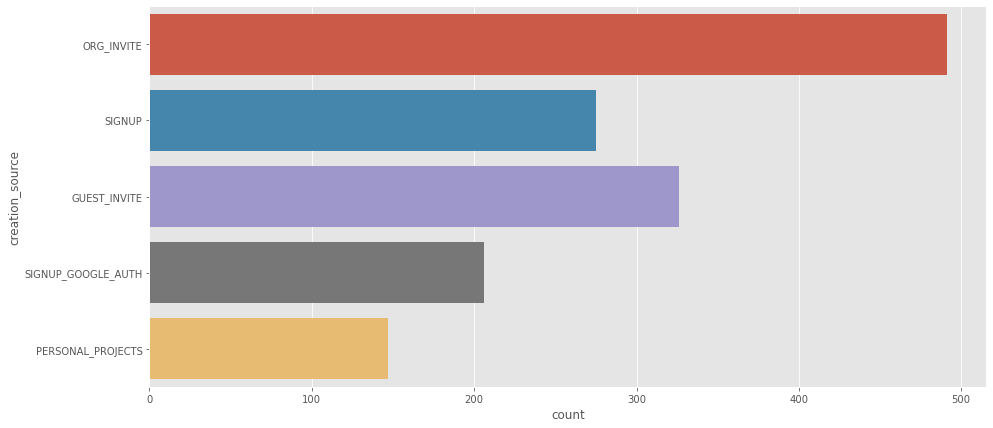

In [34]:
plt.figure(figsize=[15,7])
sns.countplot(y='creation_source',data=df_users_ad[df_users_ad['adopted_user']==1])

Highest adopted users based on org_invite

In [274]:
df_users_ad['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

<AxesSubplot:xlabel='count', ylabel='enabled_for_marketing_drip'>

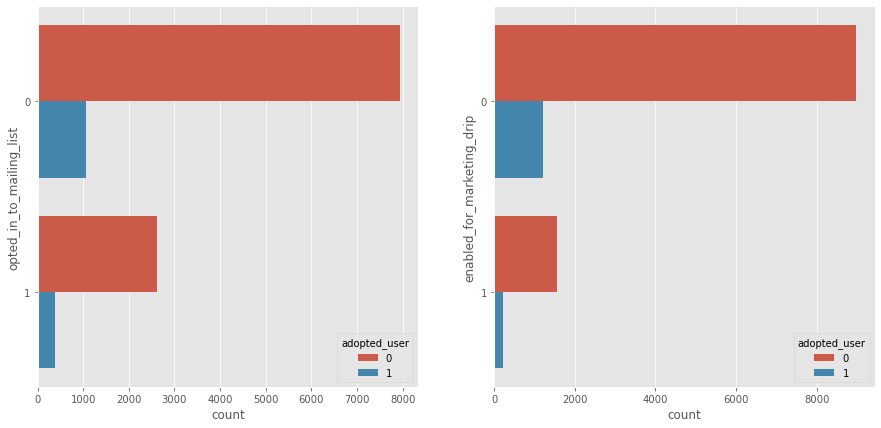

In [276]:
f,ax = plt.subplots(1,2,figsize=(15,7))
sns.countplot(y='opted_in_to_mailing_list',hue='adopted_user',data=df_users_ad,ax=ax[0])
sns.countplot(y='enabled_for_marketing_drip',hue='adopted_user',data=df_users_ad,ax=ax[1])

<AxesSubplot:xlabel='count', ylabel='enabled_for_marketing_drip'>

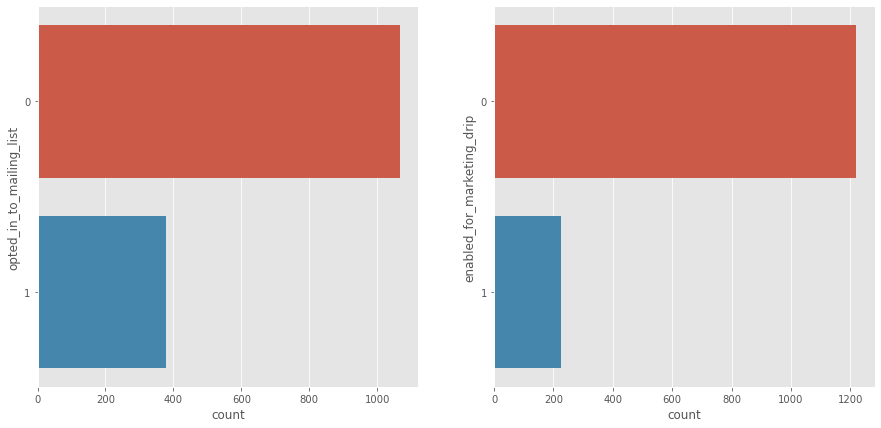

In [38]:
f,ax = plt.subplots(1,2,figsize=(15,7))
sns.countplot(y='opted_in_to_mailing_list',data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[0])
sns.countplot(y='enabled_for_marketing_drip',data=df_users_ad[df_users_ad['adopted_user']==1],ax=ax[1])

Majority of the adopted users have not opted for mailing lists or marketing drips.

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64


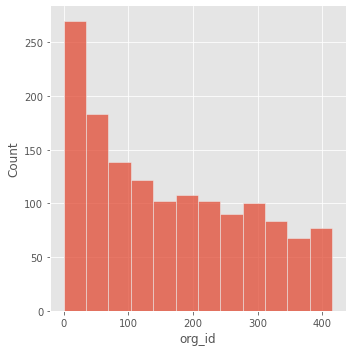

In [39]:
print(df_users_ad['org_id'].value_counts())
sns.displot(df_users_ad[df_users_ad['adopted_user']==1]['org_id'],kde=False)
plt.tight_layout()

In [277]:
def cyclic_feat(df,variable):
    #Month Cyclicity
    df[variable+'_sin'] = np.sin(df[variable]*(2*np.pi/12))
    df[variable+'_cos'] = np.cos(df[variable]*(2*np.pi/12))
    return df

Cyclical nature of time features created from creation_time and last_session_creation_time can be preserved by transforming into sine and cosine components

In [278]:
df_users_ad = cyclic_feat(df_users_ad,'creation_time_Month_No')
df_users_ad = cyclic_feat(df_users_ad,'creation_time_Day_of_Week')
df_users_ad = cyclic_feat(df_users_ad,'creation_time_Hour')
df_users_ad = cyclic_feat(df_users_ad,'last_session_creation_time_Month_No')
df_users_ad = cyclic_feat(df_users_ad,'last_session_creation_time_Day_of_Week')
df_users_ad = cyclic_feat(df_users_ad,'last_session_creation_time_Hour')

In [282]:
df_ml = df_users_ad.copy()

Create dummy features for the creation source feature dropping the first column. Drop original extracted date features.

In [283]:
dummies = pd.get_dummies(df_ml[['creation_source']],drop_first=True)
df_ml = pd.concat([df_ml,dummies],axis=1)
df_ml = df_ml.drop(['creation_source'],axis=1)
#df_ml = df_ml.drop(['creation_time_Month_No','creation_time_Day_of_Week', 'creation_time_Hour',
#                    'last_session_creation_time_Month_No','last_session_creation_time_Day_of_Week', 
#                    'last_session_creation_time_Hour'],axis=1)
df_ml.columns

Index(['object_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user', 'creation_time_Year', 'creation_time_Month_No',
       'creation_time_Day_of_Week', 'creation_time_Hour', 'creation_time_Day',
       'creation_time_Month', 'creation_time_Y/M',
       'last_session_creation_time_Year',
       'last_session_creation_time_Month_No',
       'last_session_creation_time_Day_of_Week',
       'last_session_creation_time_Hour', 'last_session_creation_time_Day',
       'last_session_creation_time_Month', 'last_session_creation_time_Y/M',
       'creation_time_Month_No_sin', 'creation_time_Month_No_cos',
       'creation_time_Day_of_Week_sin', 'creation_time_Day_of_Week_cos',
       'creation_time_Hour_sin', 'creation_time_Hour_cos',
       'last_session_creation_time_Month_No_sin',
       'last_session_creation_time_Month_No_cos',
       'last_session_c

In [289]:
clmns = ['opted_in_to_mailing_list','enabled_for_marketing_drip','adopted_user','creation_time_Month_No_sin', 
         'creation_time_Month_No_cos','creation_time_Day_of_Week_sin', 'creation_time_Day_of_Week_cos',
         'creation_time_Hour_sin', 'creation_time_Hour_cos','last_session_creation_time_Month_No_sin',
         'last_session_creation_time_Month_No_cos','last_session_creation_time_Day_of_Week_sin',
         'last_session_creation_time_Day_of_Week_cos','last_session_creation_time_Hour_sin',
         'last_session_creation_time_Hour_cos', 'creation_source_ORG_INVITE','creation_source_PERSONAL_PROJECTS', 
         'creation_source_SIGNUP','creation_source_SIGNUP_GOOGLE_AUTH']

Drop unnecessary features. Also, drop missing rows for the last session creation time feature.

In [287]:
#df_ml['last_session_creation_time'] = df_ml['last_session_creation_time'].fillna(np.mean(df_ml['last_session_creation_time']))
df_ml = df_ml[clmns]
df_ml = df_ml.dropna()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   opted_in_to_mailing_list                    8823 non-null   int64  
 1   enabled_for_marketing_drip                  8823 non-null   int64  
 2   adopted_user                                8823 non-null   int64  
 3   creation_time_Month_No_sin                  8823 non-null   float64
 4   creation_time_Month_No_cos                  8823 non-null   float64
 5   creation_time_Day_of_Week_sin               8823 non-null   float64
 6   creation_time_Day_of_Week_cos               8823 non-null   float64
 7   creation_time_Hour_sin                      8823 non-null   float64
 8   creation_time_Hour_cos                      8823 non-null   float64
 9   last_session_creation_time_Month_No_sin     8823 non-null   float64
 10  last_sessio

In [288]:
#df_ml['active_days'] = (df_ml['last_session_creation_time'] - df_ml['creation_time']).dt.days.astype('float')

In [290]:
#Resampling Data
def resample_train(X_train,y_train,undersample=False,smote=False,smote_str =0.3,undersample_str=0.6):
    #Resampling techniques
    print('Pre-resampling ',Counter(y_train))
    if smote == True:
        sm = SMOTE(random_state=1,sampling_strategy=smote_str)
        #sm = SMOTE(random_state=1)
        X_train,y_train = sm.fit_resample(X_train,y_train)
        print('Oversampling (SMOTE) Class 1 = {}X Class 0 '.format(smote_str),Counter(y_train))
    #ros = RandomOverSampler()
    #X_tr_ros, y_tr_ros = ros.fit_resample(X_train,y_train)
    if undersample == True:
        rus = RandomUnderSampler(sampling_strategy=undersample_str)
        X_train, y_train = rus.fit_resample(X_train,y_train)
        print('Undersampling Class 0 for Class 1 = {}X Class 0'.format(undersample_str),Counter(y_train))
#     if smotetomek == True:
#         print('Combining SMOTE and Tomek links...')
#         smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
#         X_train, y_train = smt.fit_resample(X_train,y_train)
#         print('Combining SMOTE, TOMEK links, removing the majority class with Tomek links = {}'.format(Counter(y_train)))
    return X_train, y_train

# Classifier Results
def model_metrics(y_true,y_predicted,y_pred_prob):
    sns.heatmap(confusion_matrix(y_true,y_predicted),annot=True,fmt='g',cmap="Blues")
    plt.xlabel('Predicted Classes')
    plt.ylabel('Observed Classes')
    print('ROC_AUC Score: ' + str(roc_auc_score(y_true,y_pred_prob[:,1])))
    print('Accuracy_Score: ' + str(accuracy_score(y_true,y_predicted)))
    print('Precision_Score: ' + str(precision_score(y_true,y_predicted)))
    print('F1 Score: ' + str(f1_score(y_true,y_predicted)))
    print('Classification Report: ' + str(classification_report(y_true,y_predicted)))
    
# ROC / Precision Recall Curves
def roc_prerec(y_true,y_pred_prob):
    fpr, tpr, th = roc_curve(y_true,y_pred_prob[:,1])
    plt.figure(figsize=[10,10])
    plt.plot(fpr, tpr, linestyle='-.', label='Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    pre, re, the = precision_recall_curve(y_true,y_pred_prob[:,1])
    plt.figure(figsize=[10,10])
    plt.plot(re, pre, linestyle='-.', label='Random Forest')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend()

In [292]:
X = df_ml.drop('adopted_user',axis=1)
y = df_ml['adopted_user']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
#X_train,y_train = resample_train(X_train,y_train,smote=True,smote_str=1,undersample=False,undersample_str=0.5)
model = LGBMClassifier()
model.fit(X_train,y_train)
y_tr_pred = model.predict(X_train)
y_tr_pred_prob = model.predict_proba(X_train)
y_te_pred = model.predict(X_test)
y_te_pred_prob = model.predict_proba(X_test)

ROC_AUC Score: 0.9972941844826515
Accuracy_Score: 0.979597619722301
Precision_Score: 0.9693877551020408
F1 Score: 0.9355416293643689
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.99      0.99      5902
           1       0.97      0.90      0.94      1156

    accuracy                           0.98      7058
   macro avg       0.98      0.95      0.96      7058
weighted avg       0.98      0.98      0.98      7058



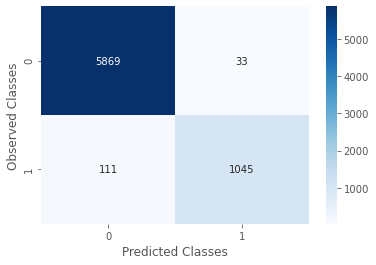

In [293]:
model_metrics(y_train,y_tr_pred,y_tr_pred_prob)

ROC_AUC Score: 0.9693164448945528
Accuracy_Score: 0.9376770538243626
Precision_Score: 0.8377358490566038
F1 Score: 0.8014440433212996
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1476
           1       0.84      0.77      0.80       289

    accuracy                           0.94      1765
   macro avg       0.90      0.87      0.88      1765
weighted avg       0.94      0.94      0.94      1765



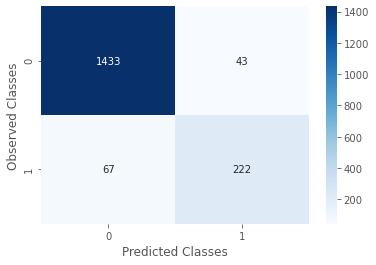

In [294]:
model_metrics(y_test,y_te_pred,y_te_pred_prob)

In [295]:
features = pd.DataFrame(model.feature_importances_, X.columns).reset_index().rename(columns={'index':'feature',0:'importance'})

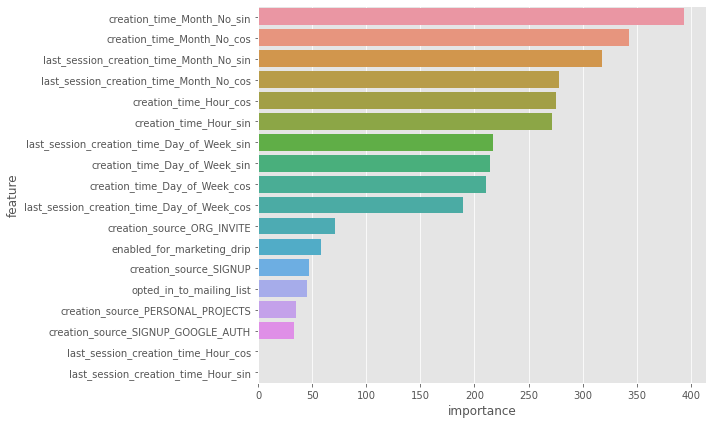

In [301]:
plt.figure(figsize=(10,6))
feat_imp = sns.barplot(y='feature', x='importance',data=features.nlargest(100,'importance'));
plt.tight_layout()
feat_imp.get_figure().savefig('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Machine Learning Case Studies/relax_challenge/feat_imp.png')

As seen from the plot above, date features extracted from the creation_time and last_session_creation_time_feature account for most of the predictive power of the light gradient boost model. The model was fit dropping the missing rows for last session time. It may be imputed with a mean last session date to incorporate more information although it may be very simplistic in assuming an average session.